<a href="https://colab.research.google.com/github/Marfiik/GRBorNotGRB/blob/main/LSTM_rate_one_var.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit
from astropy.time import Time

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, LambdaCallback, EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.losses import MeanSquaredError

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, confusion_matrix

In [ ]:
%cd ..
%cd ..
%cd gdrive/MyDrive/diplomka/
%ls

/
/
/gdrive/MyDrive/diplomka
2rate_ch_geq_64.txt                 data_gen-4CH.ipynb
3rate_ch_geq_64.txt                 data_gen_chng_bkg.ipynb
autoencoder_conv1d/                 data_gen_chng_bkg.py
autoencoder_conv1d_norm/            GRB-detection-main.UzXw0sQv.zip.part
autoencoder_conv1d_test.ipynb       logs/
autoencoder_conv1d_test_norm.ipynb  logs_real/
autoencoder_dense/                  ML_kolar_final.ipynb
autoencoder_dense_16_norm/          Old/
autoencoder_dense_16_norm.ipynb     predict_info-Copy1.ipynb
autoencoder_dense_16_super/         predict_info.ipynb
autoencoder_dense_16_super2/        predict_info.py
autoencoder_dense_16_super.ipynb    pred_SN_ratio.ipynb
autoencoder_dense_2/                __pycache__/
autoencoder_dense_8_norm/           que.ipynb
autoencoder_dense_8_norm.ipynb      read_data-Copy1.ipynb
autoencoder_dense.ipynb             read_data-GRBAlpha-Copy1.ipynb
autoencoder_dense.py                read_data-GRBAlpha.ipynb
conv1d_good/                      

In [ ]:
df = pd.read_csv("3rate_ch_geq_64.txt",sep="\s+")
df

,,chunk_id,data_id,exp_start_time,exp_end_time,sec_from_1st_exp_start,lon_start,lat_start,alt_start,lon_end,lat_end,...,spec_nbins,n_chunks,spec_bin_thr,ch_thr,cutoff,temp1(°C),temp2(°C),temp3(°C),counts(cnt),rate(cps)
0,7199,2022-08-08,23:45:21.405963,2022-08-08,23:45:25.405963,0,354.116,48.1902,563.208,354.026,47.9446,...,16,1323969,4,64,54,14.09,14.28,13.28,379.0,94.75
1,7198,2022-08-08,23:45:25.405980,2022-08-08,23:45:29.405980,4,354.026,47.9446,563.172,353.937,47.6989,...,16,1323969,4,64,54,NaN,NaN,NaN,383.0,95.75
2,7197,2022-08-08,23:45:29.405984,2022-08-08,23:45:33.405984,8,353.937,47.6989,563.136,353.849,47.4532,...,16,1323969,4,64,54,NaN,NaN,NaN,382.0,95.50
3,7196,2022-08-08,23:45:33.405987,2022-08-08,23:45:37.405987,12,353.849,47.4532,563.100,353.761,47.2074,...,16,1323969,4,64,54,NaN,NaN,NaN,419.0,104.75
4,7195,2022-08-08,23:45:37.405988,2022-08-08,23:45:41.405988,16,353.761,47.2074,563.063,353.674,46.9616,...,16,1323969,4,64,54,NaN,NaN,NaN,372.0,93.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5828,27132,2023-02-18,16:27:47.377104,2023-02-18,16:27:48.377104,16738946,102.963,50.2681,545.127,102.939,50.2065,...,4,1323969,1,64,54,NaN,NaN,NaN,113.0,113.00
5829,27131,2023-02-18,16:27:48.377104,2023-02-18,16:27:49.377104,16738947,102.939,50.2065,545.129,102.915,50.1449,...,4,1323969,1,64,54,NaN,NaN,NaN,139.0,139.00
5830,27130,2023-02-18,16:27:49.377104,2023-02-18,16:27:50.377104,16738948,102.915,50.1449,545.130,102.891,50.0834,...,4,1323969,1,64,54,NaN,NaN,NaN,117.0,117.00
5831,27129,2023-02-18,16:27:50.377104,2023-02-18,16:27:51.377104,16738949,102.891,50.0834,545.132,102.867,50.0218,...,4,1323969,1,64,54,NaN,NaN,NaN,105.0,105.00


<AxesSubplot:>

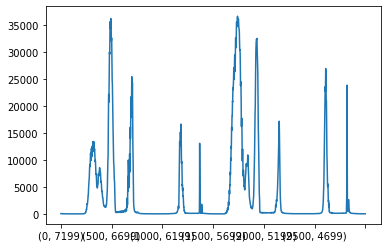

In [ ]:
rate = df["rate(cps)"]
rate[0:3000].plot()

In [ ]:
def df_to_X_y(df, window_size=10):
  df_as_np = df.to_numpy()
  print(df_as_np)
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(np.log(rate[0:30]+1), WINDOW_SIZE)
X1.shape, y1.shape

[4.56174063 4.57213033 4.56954301 4.66107782 4.54329478 4.44265126
 4.50534985 4.47449186 4.52450228 4.36944785 4.50534985 4.44851638
 4.46014441 4.40060302 4.44558812 4.40060302 4.52720864 4.28013233
 4.41582401 4.39444915 4.42184813 4.26969745 4.39444915 4.35990883
 4.23772315 4.18965474 4.41279829 4.26619482 4.37575702 4.18585967]


((25, 5, 1), (25,))

In [ ]:
X1

array([[[4.56174063],
        [4.57213033],
        [4.56954301],
        [4.66107782],
        [4.54329478]],

       [[4.57213033],
        [4.56954301],
        [4.66107782],
        [4.54329478],
        [4.44265126]],

       [[4.56954301],
        [4.66107782],
        [4.54329478],
        [4.44265126],
        [4.50534985]],

       ...,

       [[4.8598124 ],
        [4.8978398 ],
        [4.86753445],
        [4.73619845],
        [4.94164242]],

       [[4.8978398 ],
        [4.86753445],
        [4.73619845],
        [4.94164242],
        [4.77068462]],

       [[4.86753445],
        [4.73619845],
        [4.94164242],
        [4.77068462],
        [4.66343909]]])

In [ ]:
X_train, y_train, X_test, y_test = X1[0:99999],y1[0:99999],X1[100000:],y1[100000:]

In [ ]:
model1 = Sequential()
model1.add(InputLayer((WINDOW_SIZE, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

In [ ]:
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])
model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5)

In [ ]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':(10**test_predictions)-1, 'Actuals':(10**y_test)-1})
test_results

# GRBalpha (true) detections

In [ ]:
plt.plot(test_results['Test Predictions'][15342:15389])
plt.plot(test_results['Actuals'][15342:15389])

In [ ]:
plt.plot(test_results['Test Predictions'][23924:24000])
plt.plot(test_results['Actuals'][23924:24000])